In [1]:
import math

import numpy as np
import optuna
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix, matthews_corrcoef
from sklearn.utils.class_weight import compute_class_weight

import os
from dotenv import load_dotenv
from sklearn.model_selection import train_test_split

from data_manipulation.reading_util import load_non_enz_esm2
from collections import Counter
from data_manipulation.reading_util import load_all_sub_classes
from imblearn.over_sampling import SMOTE

from sklearn.metrics import f1_score

load_dotenv()


2023-10-30 13:43:02.211574: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-30 13:43:02.432899: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-30 13:43:02.434681: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-30 13:43:04.157794: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


True

![Image of Split30](/home/malte/Desktop/Dataset/plots/class_count_comparison/SPLIT30.png)

In [2]:
emb_path = os.getenv("ESM2_ENZYMES_SPLIT_30")
csv_path = os.getenv("CSV30_ENZYMES")
wanted_ec = 1

In [ ]:
import tensorflow as tf
from keras import backend as K

def multi_mcc_loss(y_true, y_pred, false_pos_penal=1.0):
    confusion_m = tf.matmul(K.transpose(y_true), y_pred)
    if false_pos_penal != 1.0:
      """
      This part is done for penalization of FalsePos symmetrically with FalseNeg,
      i.e. FalseNeg is favorized for the same factor. In such way MCC values are comparable.
      If you want to penalize FalseNeg, than just set false_pos_penal < 1.0 ;)
      """
      confusion_m = tf.matrix_band_part(confusion_m, 0, 0) + tf.matrix_band_part(confusion_m, 0, -1)*false_pos_penal + tf.matrix_band_part(confusion_m, -1, 0)/false_pos_penal
    
    N = K.sum(confusion_m)
    
    up = N*tf.trace(confusion_m) - K.sum(tf.matmul(confusion_m, confusion_m))
    down_left = K.sqrt(N**2 - K.sum(tf.matmul(confusion_m, K.transpose(confusion_m))))
    down_right = K.sqrt(N**2 - K.sum(tf.matmul(K.transpose(confusion_m), confusion_m)))
    
    mcc = up / (down_left * down_right + K.epsilon())
    mcc = tf.where(tf.is_nan(mcc), tf.zeros_like(mcc), mcc)
    
    return 1 - K.mean(mcc)

# Extracting 2nd ec class form wanted main class
----

### Critical 2nd ec classes

| Class | Count |
|-------|-------|
| 1.10  | 10    |
| 1.20  | 8     |
| 1.23  | 2     |
| 1.97  | 7     |
| 2.2   | 19    |
| 2.9   | 5     | 
| 2.10  | 2     |
| 3.3   | 18    |
| 3.7   | 14    |
| 3.8   | 8     |
| 3.9   | 1     |
| 3.11  | 1     |
| 3.13  | 1     |
| 4.5   | 1     |
| 4.7   | 1     |
| 5.5   | 18    |
| 5.99  | 1     |
| 6.4   | 11    |
| 6.6   | 6     |
| 7.3   | 9     |
| 7.4   | 9     |
| 7.5   | 4     |
| 7.6   | 13    |
  
----


In [3]:
# all possible sub classes in split 30
ec_to_label = {
    "1.1": 0,
    "1.2": 1,
    "1.3": 2,
    "1.4": 3,
    "1.5": 4,
    "1.6": 5,
    "1.7": 6,
    "1.8": 7,
    "1.11": 8,
    "1.12": 9,
    "1.13": 10,
    "1.14": 11,
    "1.15": 12,
    "1.16": 13,
    "1.17": 14,
    "1.18": 15,
    "1.21": 16,
    "1.10": 17,
    "1.20": 18,
    "1.23": 19,
    "1.97": 20,
    "2.1": 21,
    "2.3": 22,
    "2.4": 23,
    "2.5": 24,
    "2.6": 25,
    "2.7": 26,
    "2.8": 27,
    "2.2": 28,
    "2.9": 29,
   "2.10": 30,
    "3.1": 31,
    "3.2": 32,
    "3.4": 33,
    "3.5": 34,
    "3.6": 35,
    "3.3": 36,
    "3.7": 37,
    "3.8": 38,
    "3.9": 39,
   "3.11": 40,
   "3.13": 41,
    "4.1": 42,
    "4.2": 43,
    "4.3": 44,
    "4.4": 45,
    "4.6": 46,
   "4.99": 47,
    "4.7": 48,
    "4.5": 49,
    "5.1": 50,
    "5.2": 51,
    "5.3": 52,
    "5.4": 53,
    "5.5": 54,
    "5.6": 55,
    "5.7": 56,
   "5.99": 57,
    "6.1": 58,
    "6.2": 59,
    "6.3": 60,
    "6.5": 61,
    "6.4": 62,
    "6.6": 63,
    "7.1": 64,
    "7.2": 65,
    "7.3": 66,
    "7.4": 67,
    "7.5": 68,
    "7.6": 69,
}

# Compressed 2nd subclasses when # samples in subclass < 20
comp_ec_to_label = { 
    "1.1": 0,
    "1.2": 1, 
    "1.3": 2,
    "1.4": 3,
    "1.5": 4,
    "1.6": 5,
    "1.7": 6,
    "1.8": 7,
    "1.11": 8,
    "1.12": 9,
    "1.13": 10,
    "1.14": 11,
    "1.15": 12,
    "1.16": 13,
    "1.17": 14,
    "1.18": 15,
    "1.21": 16,
    "1.10": 17,
    "1.20": 17,
    "1.23": 17,
    "1.97": 17,
    "2.1": 18,
    "2.3": 19,
    "2.4": 20,
    "2.5": 21,
    "2.6": 22,
    "2.7": 23,
    "2.8": 24,
    "2.2": 25,
    "2.9": 25,
    "2.10": 25,
    "3.1": 26,
    "3.2": 27,
    "3.4": 28,
    "3.5": 29,
    "3.6": 30,
    "3.3": 31,
    "3.7": 31,
    "3.8": 31,
    "3.9": 31,
    "3.11": 31,
    "3.13": 31,
    "4.1": 32,
    "4.2": 33,
    "4.3": 34,
    "4.4": 35,
    "4.6": 36,
    "4.99": 37,
    "4.7": 37,
    "4.5": 37,
    "5.1": 38,
    "5.2": 39,
    "5.3": 40,
    "5.4": 41,
    "5.5": 42,
    "5.6": 43,
    "5.7": 43,
    "5.99": 43,
    "6.1": 44,
    "6.2": 45,
    "6.3": 46,
    "6.5": 47,
    "6.4": 47,
    "6.6": 47,
    "7.1": 48,
    "7.2": 49,
    "7.3": 50,
    "7.4": 50,
    "7.5": 50,
    "7.6": 50,
}


comp_label_to_ec = {
 0: "1.1" ,
 1: "1.2" ,
 2: "1.3" ,
 3: "1.4" ,
 4: "1.5" ,
 5: "1.6" ,
 6: "1.7" ,
 7: "1.8" ,
 8: "1.11" ,
 9: "1.12" ,
 10: "1.13" ,
 11: "1.14" ,
 12: "1.15" ,
 13: "1.16" ,
 14: "1.17" ,
 15: "1.18" ,
 16: "1.21" ,
 17: "1.10_20_23_97" ,
 18: "2.1" ,
 19: "2.3" ,
 20: "2.4" ,
 21: "2.5" ,
 22: "2.6" ,
 23: "2.7" ,
 24: "2.8" ,
 25: "2.2_9_19" ,
 26: "3.1" ,
 27: "3.2" ,
 28: "3.4" ,
 29: "3.5" ,
 30: "3.6" ,
 31: "3.3_7_8_9_11_13" ,
 32: "4.1" ,
 33: "4.2" ,
 34: "4.3" ,
 35: "4.4" ,
 36: "4.6" ,
 37: "4.99_7_5" ,
 38: "5.1" ,
 39: "5.2" ,
 40: "5.3" ,
 41: "5.4" ,
 42: "5.5" ,
 43: "5.6_7_99" ,
 44: "6.1" ,
 45: "6.2" ,
 46: "6.3" ,
 47: "6.5_4_6" ,
 48: "7.1" ,
 49: "7.2" ,
 50: "7.3_4_5_6" ,
}


In [4]:
print(len(comp_ec_to_label))
print(len(ec_to_label))

70
70


In [5]:
X, y, label_to_ec = load_all_sub_classes(emb_path, csv_path, allowed_labels=comp_ec_to_label)




LOG: 3 Sequences with aa O in /home/malte/Desktop/Dataset/data/enzymes/csv/split30.csv
LOG: 15 Sequences with aa U in /home/malte/Desktop/Dataset/data/enzymes/csv/split30.csv
LOG: 203 multifunctional enzymes with diff ec main classes in /home/malte/Desktop/Dataset/data/enzymes/csv/split30.csv
LOG: 221 entries will be ignored
LOG: Data loaded in: 1.146 min
LOG: ESM2 of enzymes: 9204
LOG: Labels of enzymes: 9204


In [8]:
# y_encoded = tf.keras.utils.to_categorical(y, num_classes=len(label_to_ec))

# oversample = SMOTE()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

# X_train_dup = np.vstack((X_train, X_train))
# y_train_dup = np.hstack((y_train, y_train))

# y_train_dup_encoded = tf.keras.utils.to_categorical(y_train_dup, num_classes=len(label_to_ec))

# Our labels need to be one hot encoded
y_train_encoded = tf.keras.utils.to_categorical(y_train, num_classes=len(label_to_ec))
y_test_encoded = tf.keras.utils.to_categorical(y_test, num_classes=len(label_to_ec))

In [6]:

def calculate_f1(y_true, y_pred):
    return f1_score(y_true, y_pred, average='micro'), "Micro F1-Score"


In [30]:
print(len(X_train))
print(len(y_train))

6442
6442


In [31]:
print(max(y))

69


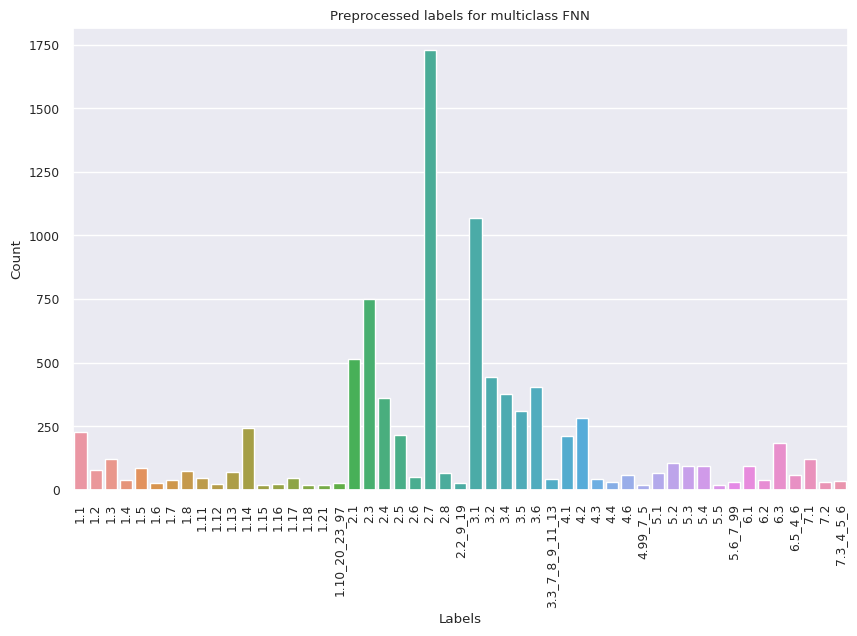

In [35]:
y_sorted = y.copy()
y_sorted.sort()

y_ec_classes = [comp_label_to_ec[label] for label in y_sorted]
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))  # Adjust the figure size if needed
sns.set(font_scale=0.8)  # Adjust font size as needed

countplot = sns.countplot(x=y_ec_classes)
countplot.set_xticklabels(countplot.get_xticklabels(), rotation=90)

# Add labels and title
plt.title("Preprocessed labels for multiclass FNN")
plt.xlabel("Labels")
plt.ylabel("Count")

# Show the plot
plt.show()

# Training a CNN based on amount of y_labels
----

In [10]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
# Our labels need to be one hot encoded
# y_train_encoded = tf.keras.utils.to_categorical(y_train, num_classes=len(sec_to_label))
# y_test_encoded = tf.keras.utils.to_categorical(y_test, num_classes=len(sec_to_label))


# y_train_encoded = tf.keras.utils.to_categorical(y_train, num_classes=len(label_to_ec))
# y_test_encoded = tf.keras.utils.to_categorical(y_test, num_classes=len(label_to_ec))



In [11]:
print(y_test_encoded[0])
print(len(X_train))

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0.]
12885


# Optimizing with Optuna
----

In [10]:
def objective(trial):
    # Define hyperparameters to be optimized
    num_units_dense_1 = trial.suggest_int('num_units_dense_1', 32, 512)
    dropout_rate_1 = trial.suggest_float('dropout_rate_1', 0.0, 0.7)
    num_units_dense_2 = trial.suggest_int('num_units_dense_2', 32, 256)
    dropout_rate_2 = trial.suggest_float('dropout_rate_2', 0.0, 0.7)
    num_units_dense_3 = trial.suggest_int('num_units_dense_3', 16, 182)

    # Create the model with the suggested hyperparameters
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(units=num_units_dense_1, activation='relu', input_shape=(2560,)))
    model.add(tf.keras.layers.Dropout(dropout_rate_1))
    model.add(tf.keras.layers.Dense(units=num_units_dense_2, activation='relu'))
    model.add(tf.keras.layers.Dropout(dropout_rate_2))
    model.add(tf.keras.layers.Dense(units=num_units_dense_3, activation='relu'))
    
    model.add(tf.keras.layers.Dense(units=len(label_to_ec), activation='softmax'))

    
    # Compile the model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Split your data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)
    # Calculate class weights
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)

    # Convert class weights to a dictionary
    class_weight_dict = dict(enumerate(class_weights))

    y_train_encoded = tf.keras.utils.to_categorical(y_train, num_classes=len(label_to_ec))
    y_val_encoded = tf.keras.utils.to_categorical(y_val, num_classes=len(label_to_ec))

    # Define early stopping callback
    early_stop = tf.keras.callbacks.EarlyStopping(patience=10)

    # Train the model
    history = model.fit(X_train, y_train_encoded, validation_data=(X_val, y_val_encoded), epochs=40, callbacks=[early_stop], verbose=0, class_weight=class_weight_dict)

    # Get the best validation loss
    val_loss = min(history.history['val_loss'])

    return val_loss


In [16]:
def f1_loss(y_true, y_pred):
    # Ensure the predicted values are in [0, 1] by using a sigmoid function
    y_pred = tf.math.sigmoid(y_pred)
    
    # Calculate precision and recall
    tp = tf.reduce_sum(y_true * y_pred, axis=0)
    fp = tf.reduce_sum(y_pred * (1 - y_true), axis=0)
    fn = tf.reduce_sum((1 - y_pred) * y_true, axis=0)
    
    precision = tp / (tp + fp + tf.keras.backend.epsilon())
    recall = tp / (tp + fn + tf.keras.backend.epsilon())
    
    # Calculate F1 score
    f1 = 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())
    
    # Return the negative F1 score as a loss
    return -tf.reduce_mean(f1)

In [18]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=40)  # You can adjust the number of trials as needed

In [17]:
# with weighted classes
best_params = {'num_units_dense_1': 386, 'dropout_rate_1': 0.22389168924519676, 'num_units_dense_2': 180, 'dropout_rate_2': 0.5276690456556323, 'num_units_dense_3': 100}

# v3 best
# best_params = study.best_params
# best_params = {'num_units_dense_1': 457, 'dropout_rate_1': 0.6740827127867876, 'num_units_dense_2': 149, 'dropout_rate_2': 0.1578959816342327, 'num_units_dense_3': 182}

# v1 best params
# best_params = {'num_units_dense_1': 386, 'dropout_rate_1': 0.4179955867912854, 'num_units_dense_2': 187, 'dropout_rate_2': 0.28289383930137707, 'num_units_dense_3': 54} 
best_num_units_dense_1 = best_params['num_units_dense_1']
best_dropout_rate_1 = best_params['dropout_rate_1']
best_num_units_dense_2 = best_params['num_units_dense_2']
best_dropout_rate_2 = best_params['dropout_rate_2']
best_num_units_dense_3 = best_params['num_units_dense_3']


# Calculate class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)

# Convert class weights to a dictionary
class_weight_dict = dict(enumerate(class_weights))

# prev b
# best_num_units_dense_1 = 482
# best_dropout_rate_1 = 0.6974068495461625
# best_num_units_dense_2 = 277
# best_dropout_rate_2 = 0.04421161571807377
# best_num_units_dense_3 = 127

# v4 {'num_units_dense_1': 457, 'dropout_rate_1': 0.6740827127867876, 'num_units_dense_2': 149, 'dropout_rate_2': 0.1578959816342327, 'num_units_dense_3': 182}

final_model = tf.keras.models.Sequential()
final_model.add(tf.keras.layers.Dense(units=best_num_units_dense_1, activation='relu', input_shape=(2560,)))
final_model.add(tf.keras.layers.Dropout(best_dropout_rate_1))
final_model.add(tf.keras.layers.Dense(units=best_num_units_dense_2, activation='relu'))
final_model.add(tf.keras.layers.Dropout(best_dropout_rate_2))
final_model.add(tf.keras.layers.Dense(units=best_num_units_dense_3, activation='relu'))

final_model.add(tf.keras.layers.Dense(units=len(label_to_ec), activation='softmax'))
final_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


# Define early stopping callback
early_stop = tf.keras.callbacks.EarlyStopping(patience=15)

final_model.fit(X_train, y_train_encoded, validation_data=(X_test, y_test_encoded), epochs=250, callbacks=[early_stop], verbose=1, class_weight=class_weight_dict)


Epoch 1/250
202/202 [==============================] - 6s 18ms/step - loss: -0.0245 - accuracy: 0.1604 - precision_1: 0.1816 - recall_1: 0.1410 - val_loss: -0.0245 - val_accuracy: 0.1973 - val_precision_1: 0.1973 - val_recall_1: 0.1973
Epoch 2/250
202/202 [==============================] - 3s 16ms/step - loss: -0.0246 - accuracy: 0.1838 - precision_1: 0.1838 - recall_1: 0.1838 - val_loss: -0.0245 - val_accuracy: 0.1973 - val_precision_1: 0.1973 - val_recall_1: 0.1973
Epoch 3/250
202/202 [==============================] - 3s 16ms/step - loss: -0.0245 - accuracy: 0.1838 - precision_1: 0.1838 - recall_1: 0.1838 - val_loss: -0.0245 - val_accuracy: 0.1973 - val_precision_1: 0.1973 - val_recall_1: 0.1973
Epoch 4/250
202/202 [==============================] - 3s 16ms/step - loss: -0.0246 - accuracy: 0.1838 - precision_1: 0.1838 - recall_1: 0.1838 - val_loss: -0.0245 - val_accuracy: 0.1973 - val_precision_1: 0.1973 - val_recall_1: 0.1973
Epoch 5/250
202/202 [==============================] - 3

KeyboardInterrupt: 

In [11]:
# Initializing the model
# model = tf.keras.models.Sequential()
# 
# earl_stop = tf.keras.callbacks.EarlyStopping(patience=3)
# 
# # Adding input layer
# model.add(tf.keras.layers.Dense(units=256, activation='relu', input_shape=(2560,)))
# 
# # Adding hidden layer
# model.add(tf.keras.layers.Dropout(0.5))  # Adding dropout for regularization
# model.add(tf.keras.layers.Dense(units=128, activation='relu'))
# model.add(tf.keras.layers.Dropout(0.5))  # Adding dropout for regularization
# model.add(tf.keras.layers.Dense(units=64, activation='relu'))
# 
# # Finally adding output layer using softmax as activation function
# model.add(tf.keras.layers.Dense(units=len(sec_to_label), activation='softmax'))  # Using softmax for multi-class classification
# 
# Compile the model
# model.compile(loss='categorical_crossentropy', optimizer='adam')


In [12]:
# model.fit(x=X_train, y=y_train_encoded, epochs=30, validation_data=(X_test, y_test_encoded), callbacks = [earl_stop])

<Figure size 1000x600 with 0 Axes>

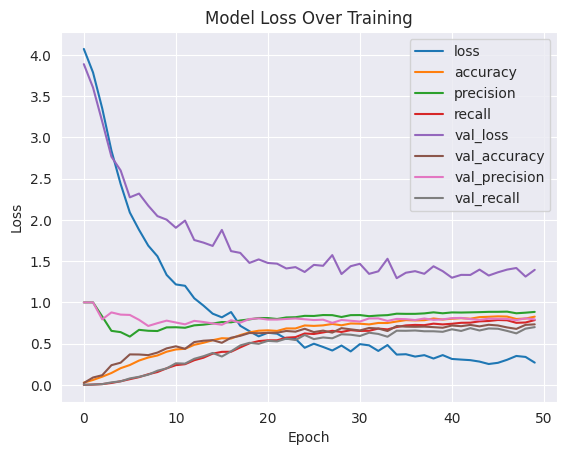

In [13]:
model_loss = pd.DataFrame(final_model.history.history)

plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
model_loss.plot()

plt.title('Model Loss Over Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()


In [14]:
predictions = np.argmax(final_model.predict(X_test), axis=-1) 

87/87 [==============================] - 1s 5ms/step


In [15]:

report = classification_report(y_test, predictions, zero_division=0)
print(report)


              precision    recall  f1-score   support

           0       0.66      0.74      0.69        68
           1       0.50      0.78      0.61        18
           2       0.86      0.69      0.77        36
           3       0.17      0.50      0.25         6
           4       0.67      0.47      0.55        34
           5       0.50      0.57      0.53         7
           6       0.55      0.43      0.48        14
           7       0.77      0.74      0.76        23
           8       0.80      0.57      0.67        14
           9       0.57      0.57      0.57         7
          10       0.44      0.71      0.55        21
          11       0.74      0.85      0.79        74
          12       1.00      1.00      1.00         2
          13       0.70      0.78      0.74         9
          14       0.88      0.47      0.61        15
          15       0.29      0.67      0.40         3
          16       0.22      0.29      0.25         7
          17       0.67    

In [53]:
def plot_report(report, y, predictions, save_path, dpi=300):
    """
    Plots results of model
    :param report: Report of model
    """
    metrics = [] 
    class_labels = list(comp_label_to_ec.values())
    class_output = []
    for i in range(2, len(report.split("\n"))-5):
        class_output.append(report.split('\n')[i].split()[0])
        metrics.append(report.split('\n')[i].split()[1:])

    precs = []
    recs = []
    f1_s = []

    for class_m in metrics:
        if len(class_m) != 0:
            precision = float(class_m[0])
            recall = float(class_m[1])
            f1_score = float(class_m[2])
            precs.append(precision)
            recs.append(recall)
            f1_s.append(f1_score)
        else:
            precision = 0
            recall = 0
            f1_score = 0
            precs.append(precision)
            recs.append(recall)
            f1_s.append(f1_score)


    # Plot accuracy for each class
    plt.figure(figsize=(10, 6))
    plt.bar(class_output, recs)
    plt.xticks(class_output, class_labels, rotation=90)
    plt.title("Recall")
    plt.xlabel("2nd EC Class")
    plt.tight_layout()
    
    
    if save_path:
        plt.savefig(f"{save_path}acc.png", dpi=dpi)
    else:
        plt.show()


    # Plot precision for each class
    plt.figure(figsize=(10, 6))
    plt.bar(class_output, precs)
    plt.xticks(class_output, class_labels, rotation=90)
    plt.title("Precision")
    plt.xlabel("2nd EC Class")
    plt.tight_layout()
    
    if save_path:
        plt.savefig(f"{save_path}weighted_prec.png", dpi=dpi)
    else:
        plt.show()


    # Plot F1 score for each class
    plt.figure(figsize=(10, 6))
    plt.bar(class_output, f1_s)
    plt.xticks(class_output, class_labels, rotation=90)
    plt.title("F1 Score")
    plt.xlabel("2nd EC Class")

    # Adjust layout
    plt.tight_layout()
    
    if save_path:
        plt.savefig(f"{save_path}weighted_f1.png", dpi=dpi)
    else:
        plt.show()


    conf_matrix = confusion_matrix(y, predictions)

    # Create a confusion matrix heatmap
    plt.figure(figsize=(10, 7))
    sns.set(font_scale=0.5)  # Adjust font size as needed
    
    heatmap = sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
    heatmap.set_yticklabels(heatmap.get_yticklabels(), rotation=0)
    # heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=15)

    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    
    plt.title("Confusion Matrix")
    
    if save_path:
        plt.savefig(f"{save_path}weighted_conf.png", dpi=dpi)
    else:
        plt.show()



In [54]:
print(len(report.split("\n")))

58


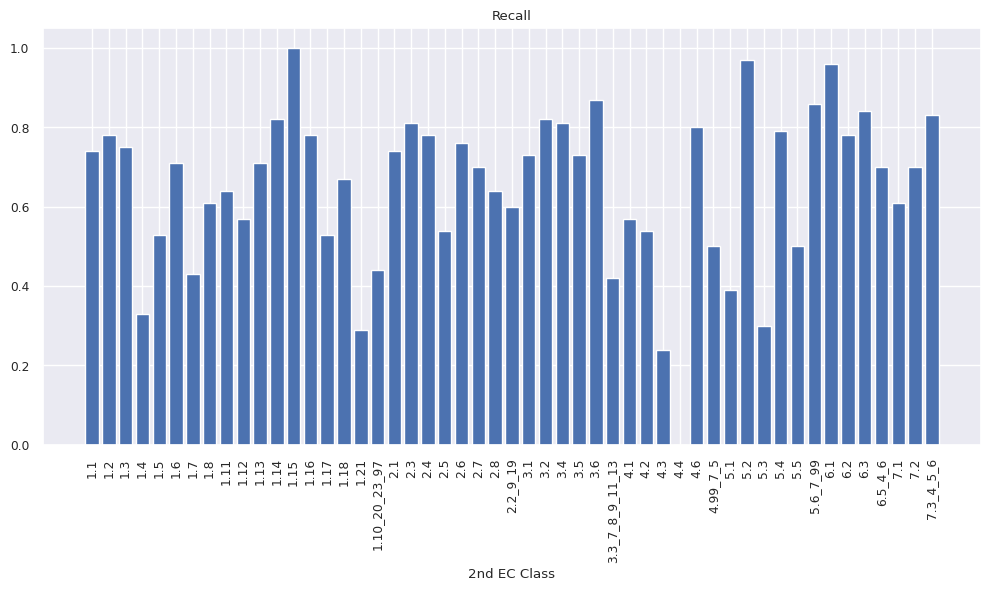

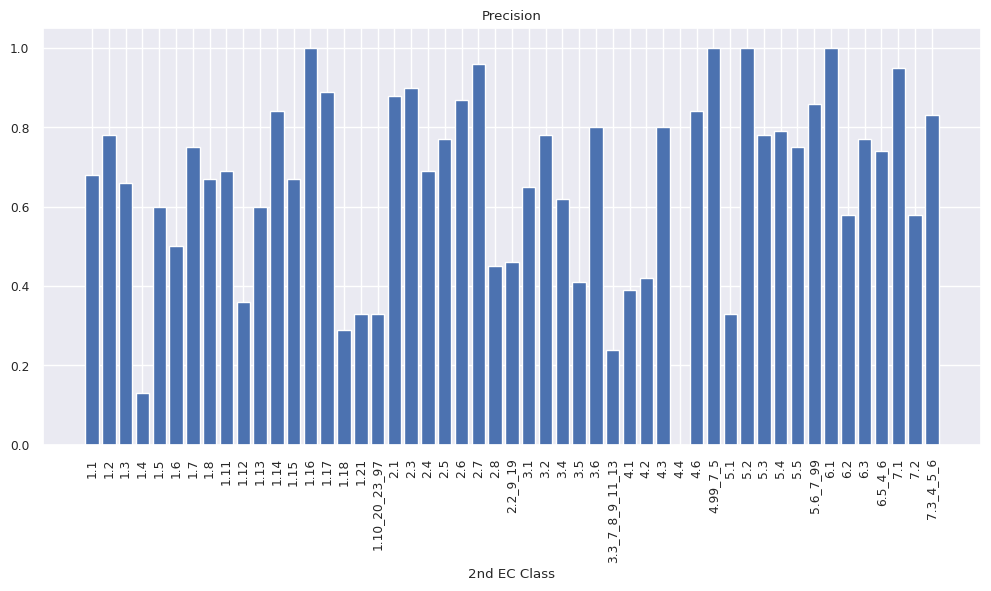

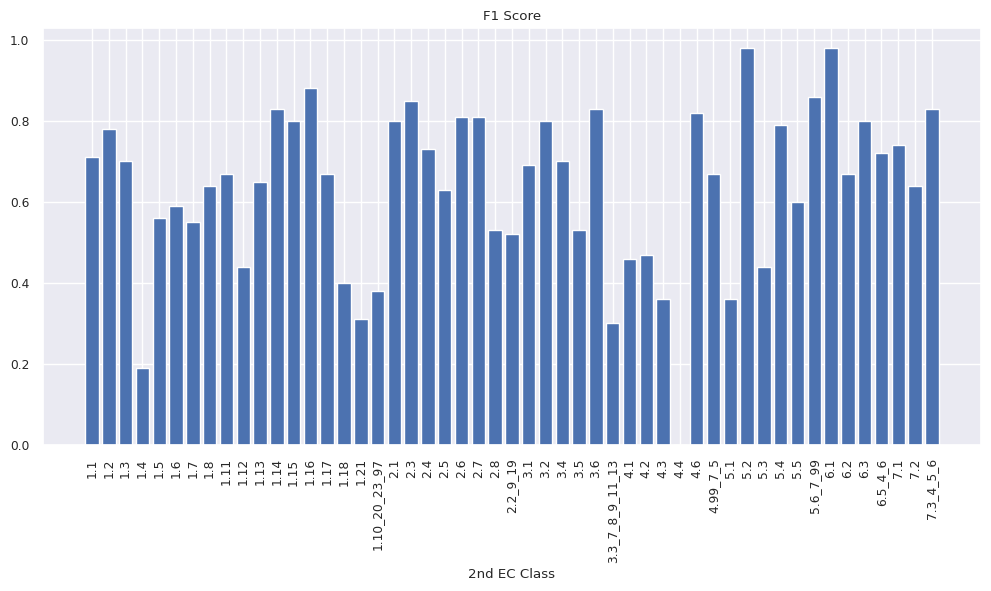

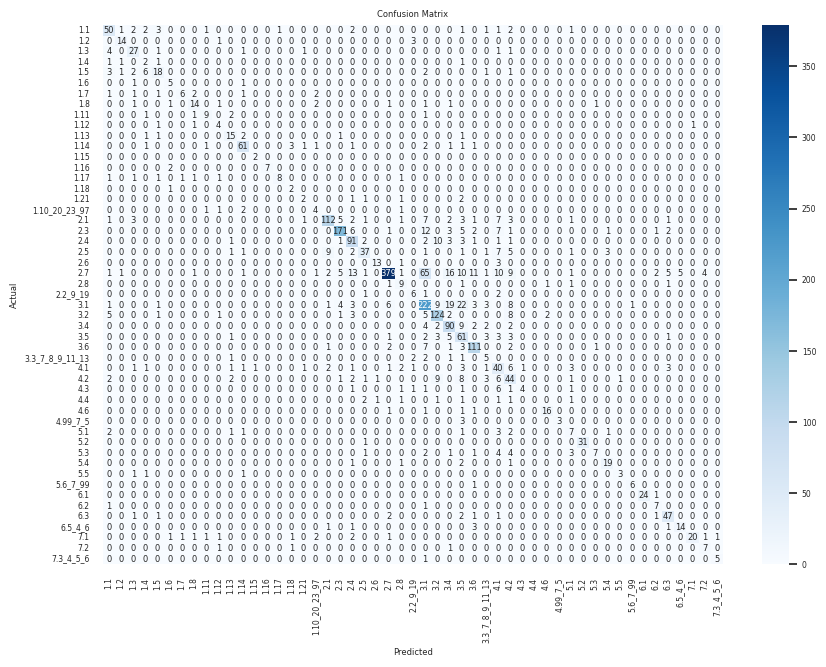

In [55]:
plot_report(report=report, y=y_test, predictions=predictions, save_path="/home/malte/Desktop/Multiclass_CNN/",
            dpi=700)

In [17]:
tf.keras.models.save_model(final_model, "/home/malte/01_Documents/projects/pbl_binary_classifier/tf_cnn_esm2/2nd_ec_class_pred/Models/CNN_S30_weighted_opt_v2.keras")



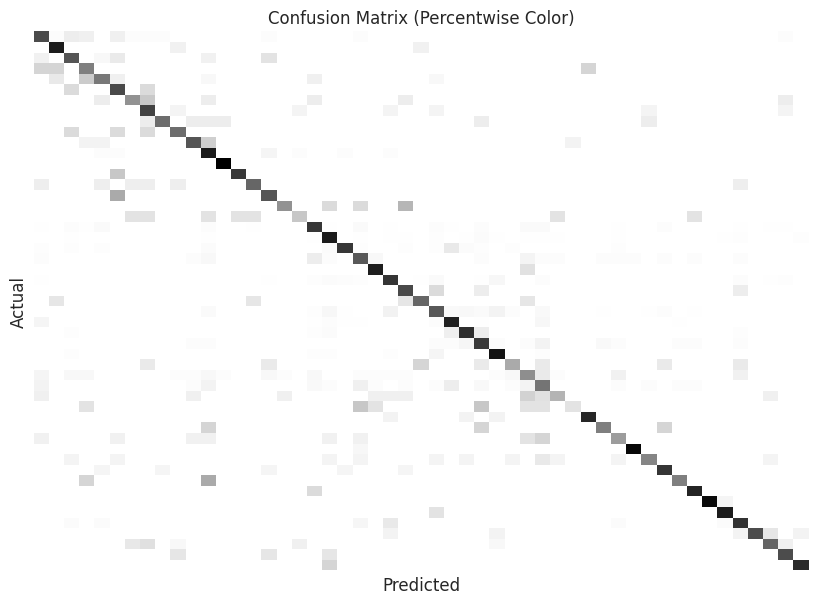

In [16]:

class_labels = list(label_to_ec.values())

conf_matrix = confusion_matrix(y_test, predictions)
row_sums = conf_matrix.sum(axis=1)
conf_matrix_percent = (conf_matrix.T / row_sums).T * 100

# Create a confusion matrix heatmap
plt.figure(figsize=(10, 7))

# Plot the heatmap with percentwise coloring
heatmap = sns.heatmap(conf_matrix_percent, annot=False, fmt=".2f", cmap="binary", cbar=False)

# Remove x and y tick labels
heatmap.set_xticks([])
heatmap.set_yticks([])

plt.xlabel("Predicted", fontsize=12)
plt.ylabel("Actual", fontsize=12)

plt.title("Confusion Matrix (Percentwise Color)", fontsize=12)
plt.show()

# Validation

In [4]:

import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score

model = tf.keras.models.load_model("/home/malte/01_Documents/projects/pbl_binary_classifier/tf_cnn_esm2/2nd_ec_class_pred/Models/CNN_S30_weighted_opt_v2.keras")

emb_path = os.getenv("ESM2_ENZYMES_SPLIT_30")
csv_path = os.getenv("CSV30_ENZYMES")

X, y, label_to_ec = load_all_sub_classes(emb_path, csv_path, allowed_labels=comp_ec_to_label)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

predictions = np.argmax(model.predict(X_test), axis=-1)

counter = 0
for x,y in zip(y_test,predictions):
    if x == y:
        counter+=1
print("Correct predictions: ", counter)
print("Total samples predicted:", len(y_test))



LOG: 3 Sequences with aa O in /home/malte/Desktop/Dataset/data/enzymes/csv/split30.csv
LOG: 15 Sequences with aa U in /home/malte/Desktop/Dataset/data/enzymes/csv/split30.csv
LOG: 203 multifunctional enzymes with diff ec main classes in /home/malte/Desktop/Dataset/data/enzymes/csv/split30.csv
LOG: 221 entries will be ignored
LOG: Data loaded in: 1.032 min
LOG: ESM2 of enzymes: 9204
LOG: Labels of enzymes: 9204
87/87 [==============================] - 0s 3ms/step
Correct predictions:  2069
Total samples predicted: 2762


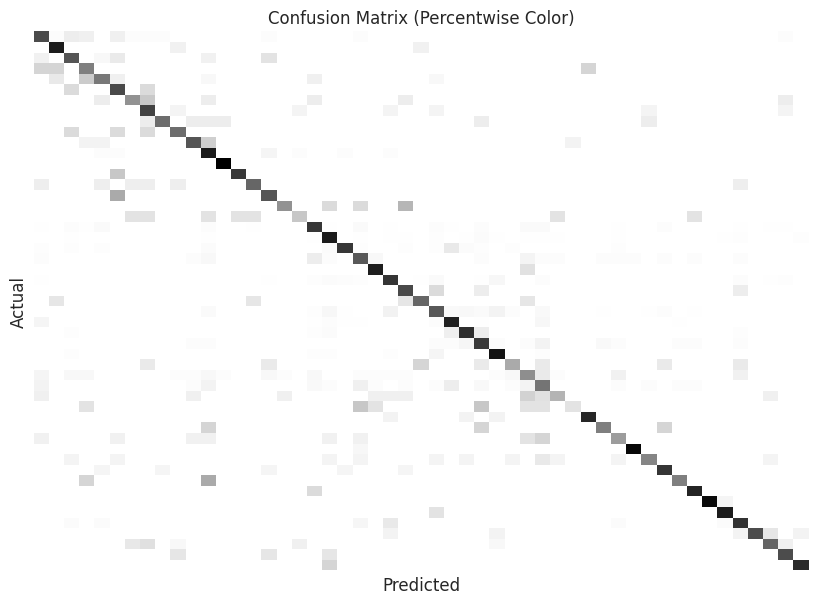

In [5]:
class_labels = list(label_to_ec.values())

conf_matrix = confusion_matrix(y_test, predictions)
row_sums = conf_matrix.sum(axis=1)
conf_matrix_percent = (conf_matrix.T / row_sums).T * 100

# Create a confusion matrix heatmap
plt.figure(figsize=(10, 7))

# Plot the heatmap with percentwise coloring
heatmap = sns.heatmap(conf_matrix_percent, annot=False, fmt=".2f", cmap="binary", cbar=False)

# Remove x and y tick labels
heatmap.set_xticks([])
heatmap.set_yticks([])

plt.xlabel("Predicted", fontsize=12)
plt.ylabel("Actual", fontsize=12)

plt.title("Confusion Matrix (Percentwise Color)", fontsize=12)
plt.show()


# Calculate standard error

In [27]:
def bootstrap_statistic(y_true, y_pred, statistic_func, B=10_000, alpha=0.05):
    bootstrap_scores = []
    for _ in range(B):
        indices = np.random.choice(len(y_pred), len(y_pred), replace=True)
        resampled_pred = y_pred[indices]
        resampled_true = y_true[indices]
        score = statistic_func(resampled_true, resampled_pred)
        bootstrap_scores.append(score)

    mean_score = np.mean(bootstrap_scores)
    standard_error = np.std(bootstrap_scores, ddof=1)
    
    # Set the range of values you want to plot (e.g., between 0.70 and 0.74)
    min_value = 0.8
    max_value = 0.9

    # Filter data within the specified range
    filtered_data = [x for x in bootstrap_scores if min_value <= x <= max_value]

    # Create the histogram
    plt.hist(filtered_data, bins=20, edgecolor='black')

    # Set the title and labels

    # Set the background color to white
    plt.gca().set_facecolor('white')

    # Set the grid color to black
    plt.grid(color='lightgrey')
    plt.title('Close-up Distribution Plot')
    plt.xlabel('F1 score')
    plt.ylabel('Frequency')

    # Show the plot
    plt.show()

    # Calculate the 95% confidence interval
    lower_bound = np.percentile(bootstrap_scores, (alpha / 2) * 100)
    upper_bound = np.percentile(bootstrap_scores, (1 - alpha / 2) * 100)

    return mean_score, standard_error, (lower_bound, upper_bound)

In [16]:
def round_to_significance(x, significance):
    if significance == 0.0:
        sig_position = 0
    else:
        sig_position = int(math.floor(math.log10(abs(significance))))
    return round(x, -sig_position), round(significance, -sig_position + 1)

In [17]:
def train_and_predict(clf, X_train, y_train, X_test):
    clf.fit(X_train, y_train)
    return clf.predict(X_test)


def calculate_f1(y_true, y_pred):
    return f1_score(y_true, y_pred, average='micro')

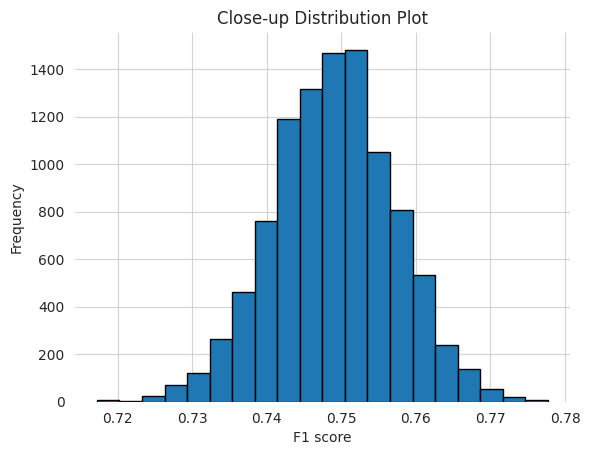

Multiclass CNN:
  - Initial F1 Score: 0.75
  - Mean ± SE: 0.749 ± 0.0081
  - 95% CI: [0.73, 0.77]


In [25]:
initial_f1 = calculate_f1(y_test, predictions)
mean_f1, se_f1, ci_95 = bootstrap_statistic(y_test, predictions, calculate_f1)

rounded_mean_f1, rounded_se_f1 = round_to_significance(mean_f1, se_f1)

print(f"Multiclass CNN:")
print(f"  - Initial F1 Score: {initial_f1:.2f}")
print(f"  - Mean ± SE: {rounded_mean_f1} ± {rounded_se_f1}")
print(f"  - 95% CI: [{ci_95[0]:.2f}, {ci_95[1]:.2f}]")

# Checking FNNs predicted values in main classes

In [24]:
y_val_main_class_labels = [int(comp_label_to_ec[label].split(".")[0]) for label in y_test]
y_pred_main_class_labels = [int(comp_label_to_ec[label].split(".")[0]) for label in predictions]

# Convert the lists to NumPy arrays
y_val_main_class_labels = np.array(y_val_main_class_labels)
y_pred_main_class_labels = np.array(y_pred_main_class_labels)

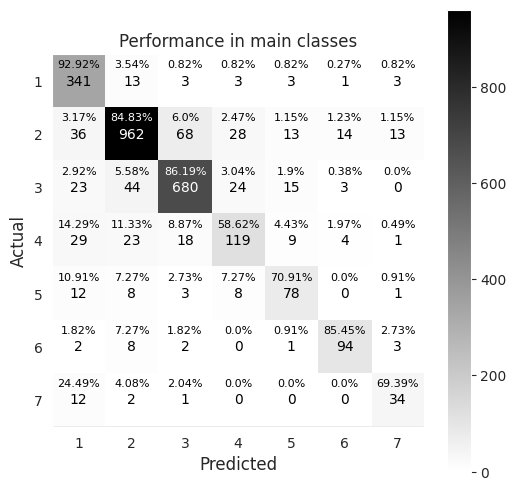

In [35]:
from sklearn.metrics import ConfusionMatrixDisplay

class_names = [1,2,3,4,5,6,7]
conf_matrix = confusion_matrix(y_val_main_class_labels, y_pred_main_class_labels)
conf_matrix_percent = (conf_matrix.T / row_sums).T * 100

# Calculate the percentages
cm_percentage = (conf_matrix / conf_matrix.sum(axis=1)[:, np.newaxis]) * 100
cm_percentage = cm_percentage.round(2)

# Create a ConfusionMatrixDisplay without labels
cmd = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_percent, display_labels=class_names)
# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(6, 6))
cmd.plot(cmap="binary", ax=ax)
cax = ax

# Add the percentages as text annotations in the squares with specified ha and va
for i in range(7):
    for j in range(7):

        # Increase the vertical offset for the percentage text
        offset = 0.4
        text_color = cax.texts[i * 7 + j].get_color()
        ax.text(j, i - offset, f'{float(cm_percentage[i, j])}%', ha='center', va='top', color=text_color, fontsize=8, fontweight='light', zorder=4)


# Set the x and y labels
ax.set_xlabel("Predicted", fontsize=12)
ax.set_ylabel("Actual", fontsize=12)
ax.grid(False)
plt.title("Performance in main classes")

plt.show()


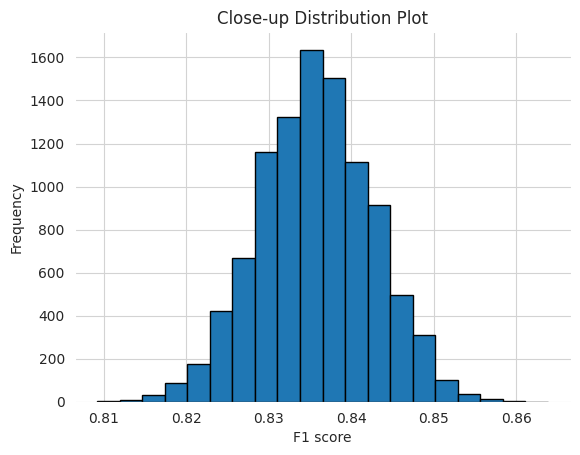

Multiclass CNN:
  - Initial F1 Score: 0.84
  - Mean ± SE: 0.836 ± 0.0069
  - 95% CI: [0.82, 0.85]


In [28]:
initial_f1 = calculate_f1(y_val_main_class_labels, y_pred_main_class_labels)
mean_f1, se_f1, ci_95 = bootstrap_statistic(y_val_main_class_labels, y_pred_main_class_labels, calculate_f1)

rounded_mean_f1, rounded_se_f1 = round_to_significance(mean_f1, se_f1)

print(f"Multiclass CNN:")
print(f"  - Initial F1 Score: {initial_f1:.2f}")
print(f"  - Mean ± SE: {rounded_mean_f1} ± {rounded_se_f1}")
print(f"  - 95% CI: [{ci_95[0]:.2f}, {ci_95[1]:.2f}]")
